# Presentation
Runan Zhang(457929) & Jakub Wnęk (444618)

# 1. Our Goal

The goal of this project is to simulate the market making trading strategy proposed in the paper "High-frequency trading in a limit order book" by Marco Avellaneda and Sasha Stoikov on a random walk stock price model. We aim to understand the behavior of stock prices in a high-frequency trading environment and validate our simulation model against the results provided in the paper.

# 2. ChatGPT Use

- Clarifying the concepts and methodologies presented in the paper.
- Generating and refining the Python code for the random walk simulation.
- Providing explanations and comments for the code to enhance understanding.
- Assisting in the structuring and writing of the presentation content.

# 3. Set Up

Packages used:
- python >= 3.9.6
- numpy >= 1.26.2
- matplotlib >= 3.8.2
- ipython >= 8.23.0
- pandas >= 2.2.1

In [1]:
# pip install -r path/to/requirements.txt
# pip list

# 4. Codes

## Step 1: Random Walk

### 1. Imports and Initialization:

In [2]:
from RandomWalk import simulate_mid_price
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Parameters
S0 = 100  # Initial stock price
sigma = 0.2  # Volatility
T = 1.0  # Total time period (e.g., 1 year)
dt = 0.005  # Time step (e.g., daily steps)

### 2. Random Seed Initialization:



In [4]:
current_time = int(time.time())
np.random.seed(current_time)

### 3. Running the function:

In [5]:
mid_prices = simulate_mid_price(S0, sigma, T, dt)
mid_prices[:10]

array([100.        , 100.01414214, 100.        ,  99.98585786,
        99.97171573,  99.98585786, 100.        , 100.01414214,
       100.02828427, 100.04242641])

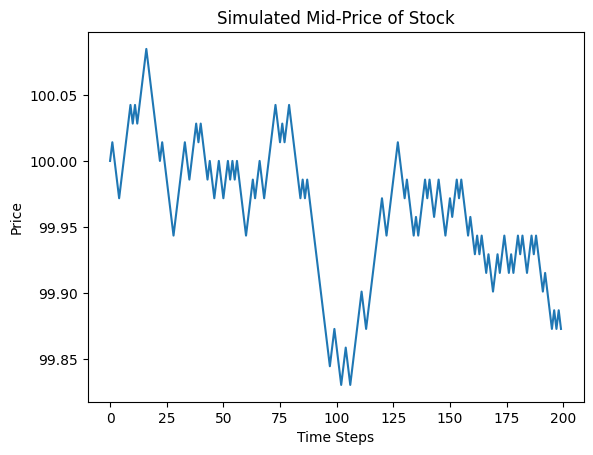

In [6]:
# Plot the results
plt.plot(mid_prices)
plt.title("Simulated Mid-Price of Stock")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()


## Step 2: Strategy Implementation

We created classes to retrieve PnL for two strategies - proposed 'inventory' strategy and benchmark 'constant spread' strategy.

Both classes ingest a random walk (list of prices) and some parameters during creation and return PnL from run_strategy() 
function. 

There are some additional elements to exactly fit what was in the paper but that’s the general idea.

### Inventory Strategy

In [7]:
from Prices import InventoryStrategy
inv_st = InventoryStrategy(mid_prices, sigma=2, theta=0.1, k=1.5, A=140, dt=0.005, T=1)
res_inv = inv_st.run_strategy()
avg_spr = inv_st.get_average_spread()
print("PnL: ", res_inv[0])
print("Avg spread: ", avg_spr)

PnL:  71.81145799570243
Avg spread:  1.6887704227514178


In [8]:
# Cell should be text type but for the sake of highlightning: 
## Important functions are:

## Here we calculate where to place our limit orders:
def calculate_bid_ask(self, mid_price, t):
        reservation_price = mid_price - self.inventory * self.theta * self.sigma**2 * (self.T - t)
        spr = self.theta*(self.sigma**2)*(self.T - self.dt) + (2/self.theta)*np.log(1 + (self.theta/self.k))
 
        bid_price = reservation_price - spr/2
        ask_price = reservation_price + spr/2

        self.spreads.append(ask_price - bid_price)
        
        return bid_price, ask_price

## Here we simulate market orders hitting the market and update our inventory
def update_inventory(self, ask, bid, mid_price, t):

        lambda_a = self.A * np.exp(-self.k * (ask - mid_price))
        lambda_b = self.A * np.exp(-self.k * (mid_price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

### Benchmark Strategy

Benchmark strategy uses symmetric bid/ask spread where spread is the average spread of the 'inventory' strategy. 

We assume it to be the 'basic' market making strategy.

In [9]:
from Prices import BenchmarkStrategy
ben_st = BenchmarkStrategy(mid_prices, avg_spr, A=140, k=1.5, dt=0.005)
res_ben = ben_st.run_strategy()
print("PnL: ", res_ben[0])

PnL:  71.7768858929835


In [10]:
## Important functions are:

## Here we calculate where to place our limit orders:
def calculate_bid_ask(self, price):
        return price - self.spread / 2, price + self.spread / 2

## Here we simulate market orders hitting the market and update our inventory
def update_inventory(self, bid, ask, price):
        
        lambda_b = self.A * np.exp(-self.k * (ask - price))
        lambda_a = self.A * np.exp(-self.k * (price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

## Step 3: Simulation

Here we try to simulate 1000 runs to replicate the results presented in the paper.

In [11]:
from Simulation import run_simulation

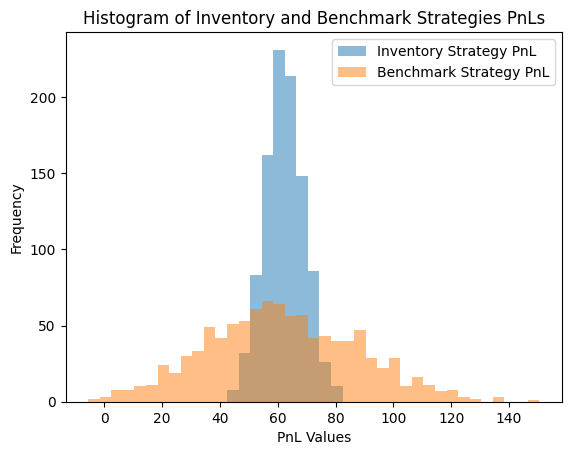

    Strategy   Mean PnL      StDev  Final Inventory  StDev(q)
0  Inventory  62.278422   6.763485           -0.411  2.760811
1  Benchmark  61.596198  26.135699           -2.310  8.163572


In [15]:
run_simulation(1000, 0.1)

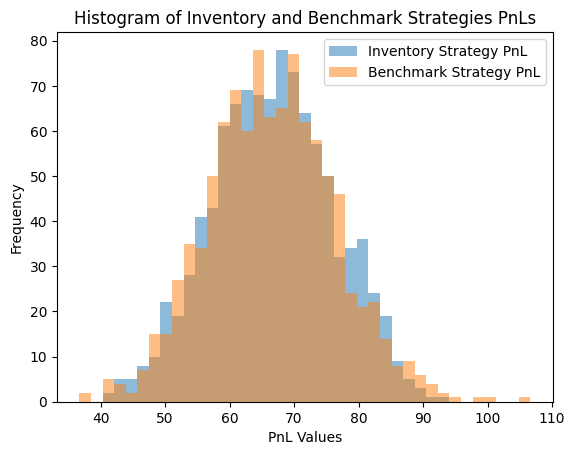

    Strategy   Mean PnL     StDev  Final Inventory  StDev(q)
0  Inventory  66.767967  9.403687            1.194  7.772153
1  Benchmark  66.606714  9.854847            1.549  8.471694


In [16]:
# in limit theta->0 both strategies should be identical. (inventory risk neutral investor)
run_simulation(1000, theta=0.001)

# 5. Summary

Our results are similar to the ones presented in the paper. There are many small things that could explain any discrepancies - authors did not specify if they performed many simulations for one random walk of prices or each simulation had its own random walk, authors also did not specify what software/programming language they used. Another thing worth mentioning are potential issues with rounding/random number generation that are solved differently between different languages. 